<a href="https://colab.research.google.com/github/dattali18/IR_Assignments/blob/main/Assignment.02/notebooks/IR_02_Classification_TFIDF-lemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IR Assignment 2

## Classification

### **Objective**:
  - Build classifiers to predict the journal group.

### **Algorithms**:
  - **Artificial Neural Network (ANN)** (two architectures provided):
      - ANN Architecture 1: RELU activation layers.
      - ANN Architecture 2: GELU activation layers.
  - **Other Classifiers**: Naive Bayes (NB), Support Vector Machine (SVM), Logistic Regression (LoR), Random Forest (RF).

### **Tasks**:
  - Perform 10-fold cross-validation for all classifiers (except ANN).
  - Identify and rank the top 20 most important features for NB, RF, SVM, LoR.
  - Write explanations for feature importance in a README document and include the ranked lists in an Excel file.
  - Check what is the top 20 most important features for NB, SVM, LoR, RF.

### **ANN Specifics**:
  - Split data: Train (80%, with 10% validation from the train set) and Test (20%).
  - Use the given ANN architectures with specific configurations:
      - Maximum 15 epochs.
      - Batch size: 32.
      - Early stopping after 3 validation iterations without improvement.
      - Save the best model (ModelCheckpoint).

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

df_aj = pd.read_excel("bm25_lemma_A-J.xlsx")
df_bbc = pd.read_excel("bm25_lemma_BBC.xlsx")
df_nyt = pd.read_excel("bm25_lemma_NY-T.xlsx")
df_jp = pd.read_excel("bm25_lemma_J-P.xlsx")

df_aj.head()

,DocumentIndex,israel,say,gaza,israeli,hamas,war,palestinian,people,attack,...,disengagement,organizations,reprehensible,unintentional,kindertransport,parliamentarian,counterprotester,indiscriminately,south.newsonline,interdisciplinary
0,0,0.000000,0.608707,1.853189,0.341663,0.0,0.016103,0.000000,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
1,1,1.840231,0.000000,0.000000,0.338359,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
2,2,0.000000,0.000000,1.934942,0.597895,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
3,3,1.248123,0.000000,1.248123,0.000000,0.0,0.015644,1.617242,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
4,4,0.000000,0.705080,2.055867,0.546761,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


In [3]:
# df_bbc = pd.read_excel("data/bm25_clean_BBC.xlsx")
# df_nyt = pd.read_excel("data/bm25_clean_NY-T.xlsx")
# df_jp = pd.read_excel("data/bm25_clean_J-P.xlsx")

print(df_bbc.shape)
print(df_nyt.shape)
print(df_jp.shape)
print(df_aj.shape)

(549, 6199)
(599, 6199)
(599, 6199)
(599, 6199)


In [4]:
# create a new df where we concat all the 4 other df but before we add a 'sheet'
# col with aj for aj etc
# remove the DocumentIndex col
# and instead add an id of aj_<index> bbc_<index>

# create an id col
df_aj['id'] = 'aj_' + df_aj['DocumentIndex'].astype(str)
df_bbc['id'] = 'bbc_' + df_bbc['DocumentIndex'].astype(str)
df_nyt['id'] = 'nyt_' + df_nyt['DocumentIndex'].astype(str)
df_jp['id'] = 'jp_' + df_jp['DocumentIndex'].astype(str)

# remove the DocumentIndex col
df_aj = df_aj.drop(columns=['DocumentIndex'])
df_bbc = df_bbc.drop(columns=['DocumentIndex'])
df_nyt = df_nyt.drop(columns=['DocumentIndex'])
df_jp = df_jp.drop(columns=['DocumentIndex'])

# add an sheet col
df_aj['Sheet'] = 'A-J'
df_bbc['Sheet'] = 'BBC'
df_nyt['Sheet'] = 'NY-T'
df_jp['Sheet'] = 'J-P'

# concat all the 4 df
df = pd.concat([df_aj, df_bbc, df_nyt, df_jp])

df.shape

(2346, 6200)

In [5]:
# reorder the col to have id and Sheet col to the start
df = df[['id', 'Sheet'] + [col for col in df.columns if col not in ['id', 'Sheet']]]

df.head()

,id,Sheet,israel,say,gaza,israeli,hamas,war,palestinian,people,...,disengagement,organizations,reprehensible,unintentional,kindertransport,parliamentarian,counterprotester,indiscriminately,south.newsonline,interdisciplinary
0,aj_0,A-J,0.000000,0.608707,1.853189,0.341663,0.0,0.016103,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,aj_1,A-J,1.840231,0.000000,0.000000,0.338359,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2,aj_2,A-J,0.000000,0.000000,1.934942,0.597895,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,aj_3,A-J,1.248123,0.000000,1.248123,0.000000,0.0,0.015644,1.617242,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,aj_4,A-J,0.000000,0.705080,2.055867,0.546761,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


In [6]:
# create the vector col
df['vector'] = df.iloc[:, 2:].values.tolist()

df.head()

,id,Sheet,israel,say,gaza,israeli,hamas,war,palestinian,people,...,organizations,reprehensible,unintentional,kindertransport,parliamentarian,counterprotester,indiscriminately,south.newsonline,interdisciplinary,vector
0,aj_0,A-J,0.000000,0.608707,1.853189,0.341663,0.0,0.016103,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[0.0, 0.6087072614680464, 1.853189492129971, 0..."
1,aj_1,A-J,1.840231,0.000000,0.000000,0.338359,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.840230999134734, 0.0, 0.0, 0.33835908243251..."
2,aj_2,A-J,0.000000,0.000000,1.934942,0.597895,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[0.0, 0.0, 1.934942053833065, 0.59789531808691..."
3,aj_3,A-J,1.248123,0.000000,1.248123,0.000000,0.0,0.015644,1.617242,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.248122821342216, 0.0, 1.248122821342216, 0...."
4,aj_4,A-J,0.000000,0.705080,2.055867,0.546761,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[0.0, 0.705079824655657, 2.055866819660789, 0...."


In [7]:
# standerdize the data mean=0 std=1
import numpy as np

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# apply to each line of the df

df['std_vector'] = df['vector'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())
df['std_vector'].head()

,std_vector
0,"[-0.06111568208121147, 1.8181979344637045, 5.6..."
1,"[6.817879904133084, -0.07009259968963384, -0.0..."
2,"[-0.06708451430912732, -0.06708451430912732, 7..."
3,"[4.339409504687963, -0.06208607680136964, 4.33..."
4,"[-0.06034887738404957, 2.6997511450036713, 7.9..."


In [8]:
# visualize the real cluster using t-SNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)

# transofrm the df['vector'] to dataframe with freatuer 0 - 99 for
df_copy = df['std_vector'].apply(pd.Series)

df_tsne = tsne.fit_transform(df_copy)

df_tsne = pd.DataFrame(df_tsne, columns=['x', 'y'])

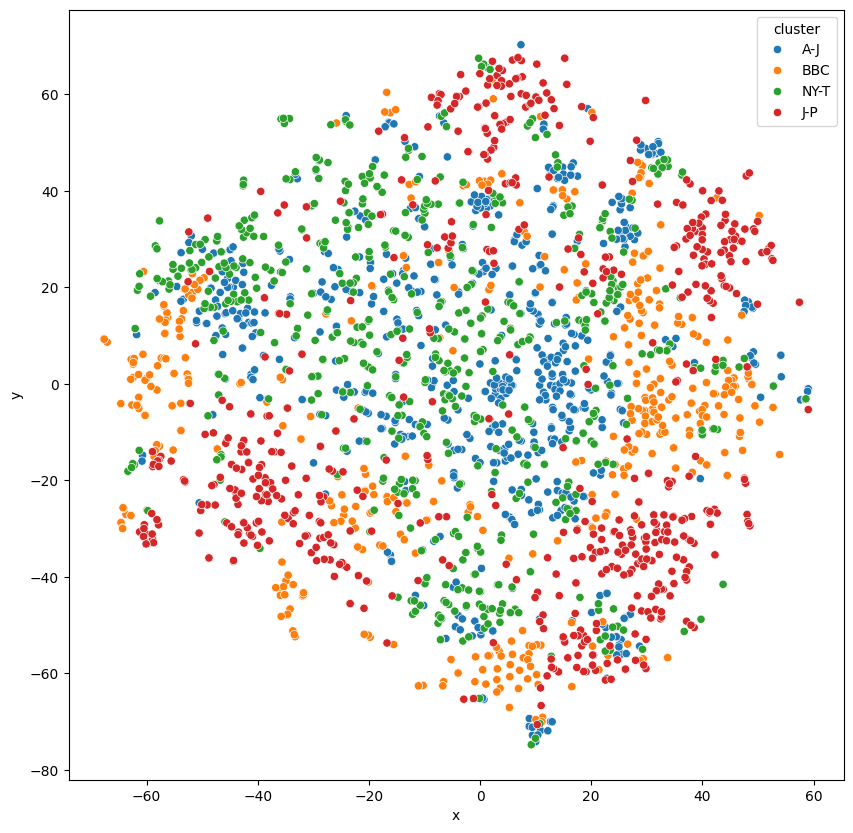

In [9]:
# plot the data
import matplotlib.pyplot as plt
import seaborn as sns

df_tsne['cluster'] = df['Sheet'].values

plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_tsne, x="x", y="y", hue="cluster")

plt.show()

In [10]:
# import all the the needed libraries NaiveBayes, SVM, LoR, RF
data = df['std_vector'].tolist()

In [11]:
data = np.array(data)

In [12]:
type(data)

numpy.ndarray

In [13]:
data.shape

(2346, 6198)

In [14]:
df['cluster'] = df['Sheet'].map({'A-J': 0, 'BBC': 1, 'NY-T': 2, 'J-P': 3})

## Naive Bayes Classifier

In [15]:
# naive bayes
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X = data
y = df['cluster'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.29, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train shape: (1665, 6198)
y_train shape: (1665,)
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


In [16]:
# use Naive Bayes with 10-fold cross validation
from sklearn.model_selection import cross_val_score

gnb = GaussianNB()

scores = cross_val_score(gnb, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.60 (+/- 0.05)


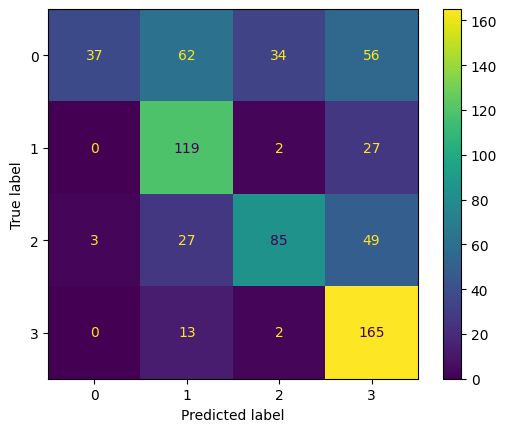

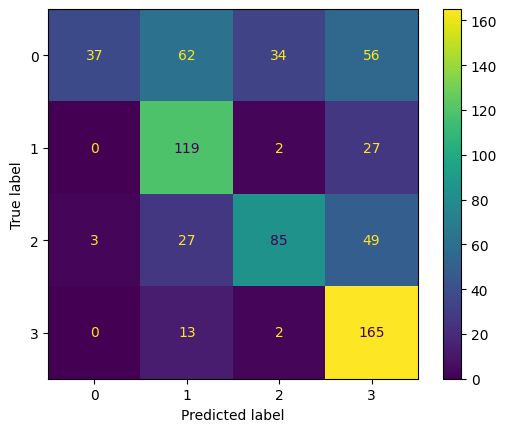

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

gnb.fit(X_train, y_train)

disp = ConfusionMatrixDisplay.from_estimator(gnb, X_test, y_test)

disp.plot()

plt.show()

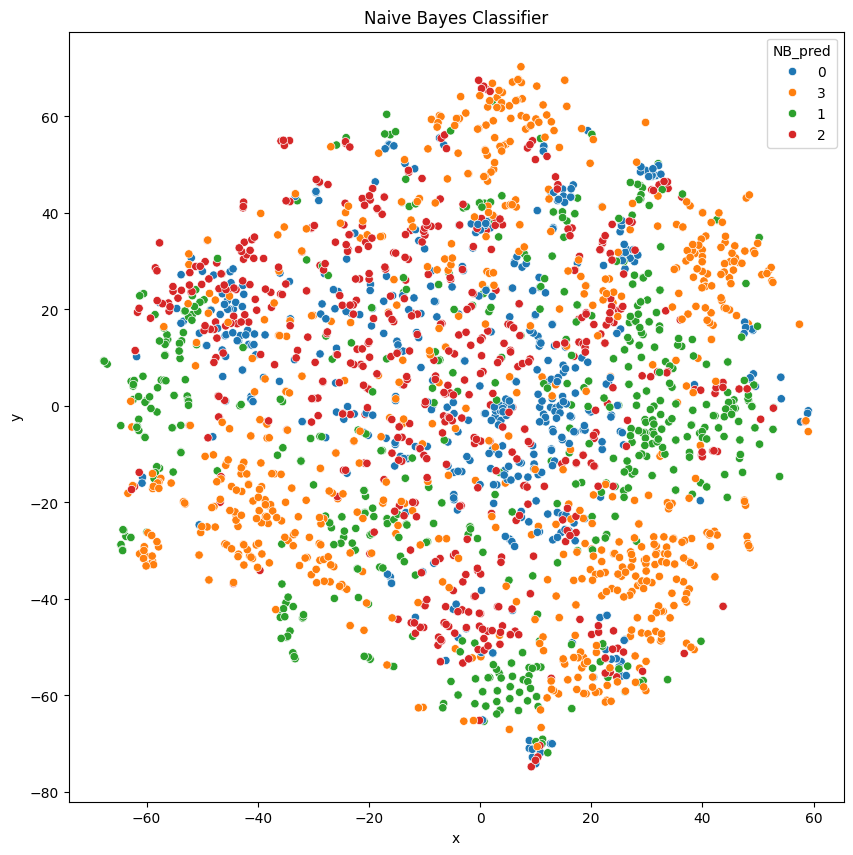

In [19]:
# get the calssification report for all X from the model and color the results using the tsne plot
df_tsne['NB_pred'] = gnb.predict(X)
df_tsne['NB_pred'] = df_tsne['NB_pred'].map(str)


plt.figure(figsize=(10, 10))

#  add title
plt.title("Naive Bayes Classifier")

sns.scatterplot(data=df_tsne, x="x", y="y", hue="NB_pred")

plt.show()

In [42]:
# get the top 20 atributes by the highest weight
theta = gnb.theta_

for k in range(4):
  print(f"Printing top 20 attribute for group k={k}")
  top20_theta = np.argsort(theta[k])[-20:]
  cols = df.columns[2:-1]
  for i in top20_theta:
      print(f"Feature {i}: {cols[i]}")

Printing top 20 attribute for group k=0
Feature 62: city
Feature 112: protest
Feature 1: say
Feature 158: student
Feature 89: hospital
Feature 154: arrest
Feature 22: day
Feature 23: force
Feature 116: university
Feature 45: rafah
Feature 17: us
Feature 21: palestinians
Feature 39: al
Feature 58: un
Feature 74: continue
Feature 6: palestinian
Feature 8: attack
Feature 12: kill
Feature 0: israel
Feature 2: gaza
Printing top 20 attribute for group k=1
Feature 6: palestinian
Feature 49: october
Feature 23: force
Feature 13: one
Feature 25: call
Feature 76: bbc
Feature 31: tell
Feature 10: would
Feature 14: military
Feature 11: also
Feature 15: take
Feature 8: attack
Feature 5: war
Feature 12: kill
Feature 7: people
Feature 4: hamas
Feature 3: israeli
Feature 2: gaza
Feature 0: israel
Feature 1: say
Printing top 20 attribute for group k=2
Feature 623: trump
Feature 1: say
Feature 14: military
Feature 1319: u.n
Feature 12: kill
Feature 5: war
Feature 3: israeli
Feature 112: protest
Feature 

## SVM - Support Vector Machine

In [43]:
# use SVM with 10-fold cross validation
from sklearn.svm import SVC

svc = SVC()

scores = cross_val_score(svc, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.93 (+/- 0.04)


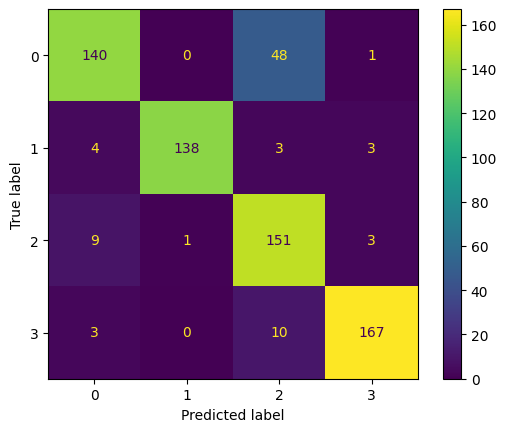

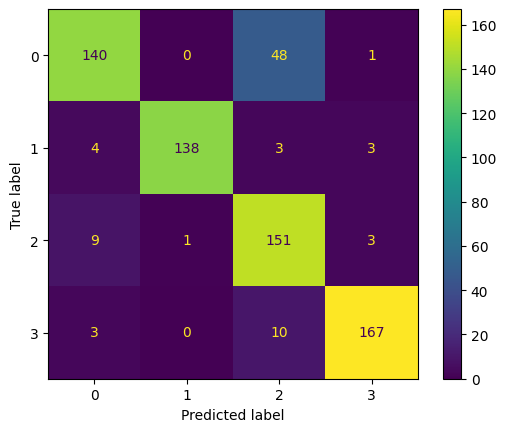

In [44]:
# same as NB

svc.fit(X_train, y_train)

disp = ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test)

disp.plot()

plt.show()

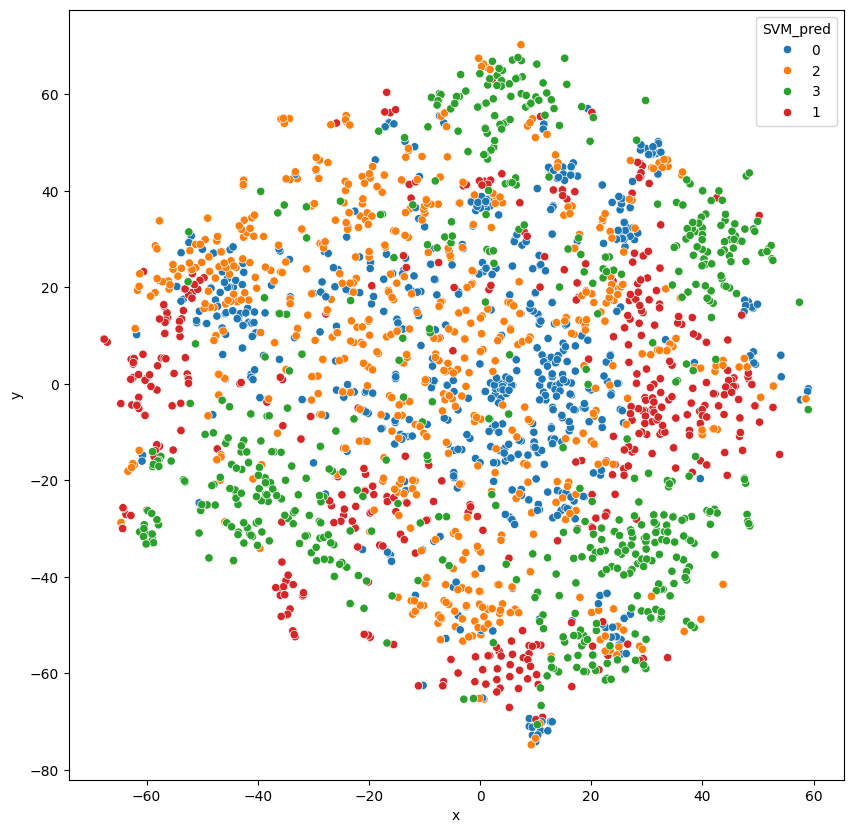

In [45]:
# get the calssification report for all X from the model and color the results using the tsne plot
df_tsne["SVM_pred"] = svc.predict(X)
df_tsne["SVM_pred"] = df_tsne["SVM_pred"].map(str)


plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_tsne, x="x", y="y", hue="SVM_pred")

plt.show()

In [48]:
weights = svc._get_coef()

# get the top 20 attributes per class

top20_attr = np.argsort(weights)[:, -20:]

for j in top20_attr[i]:
    print(f"Feature {j}: {df.columns[j+2]}")

Feature 40: official
Feature 2310: kingdom
Feature 162: launch
Feature 24: year
Feature 48: country
Feature 45: rafah
Feature 35: government
Feature 74: continue
Feature 29: netanyahu
Feature 32: state
Feature 43: strike
Feature 62: city
Feature 39: al
Feature 50: international
Feature 59: world
Feature 16: aid
Feature 34: report
Feature 58: un
Feature 2: gaza
Feature 21: palestinians


## Logistic Regression

In [49]:
# use Logistic Regression with 10-fold cross validation

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

scores = cross_val_score(lr, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.06)


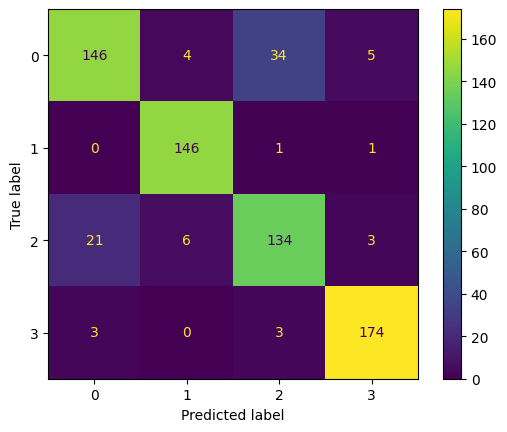

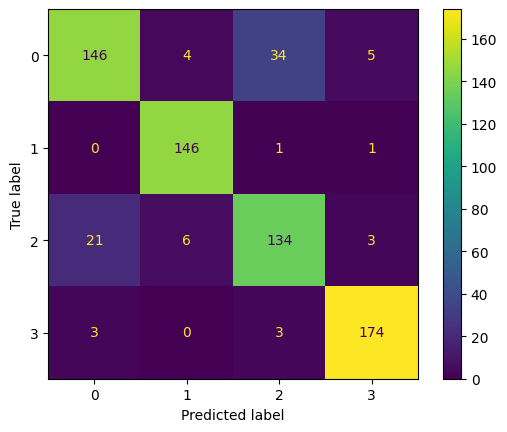

In [50]:
# same

# visualize the results of the classification for all the X

lr.fit(X_train, y_train)

disp = ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)

disp.plot()

plt.show()

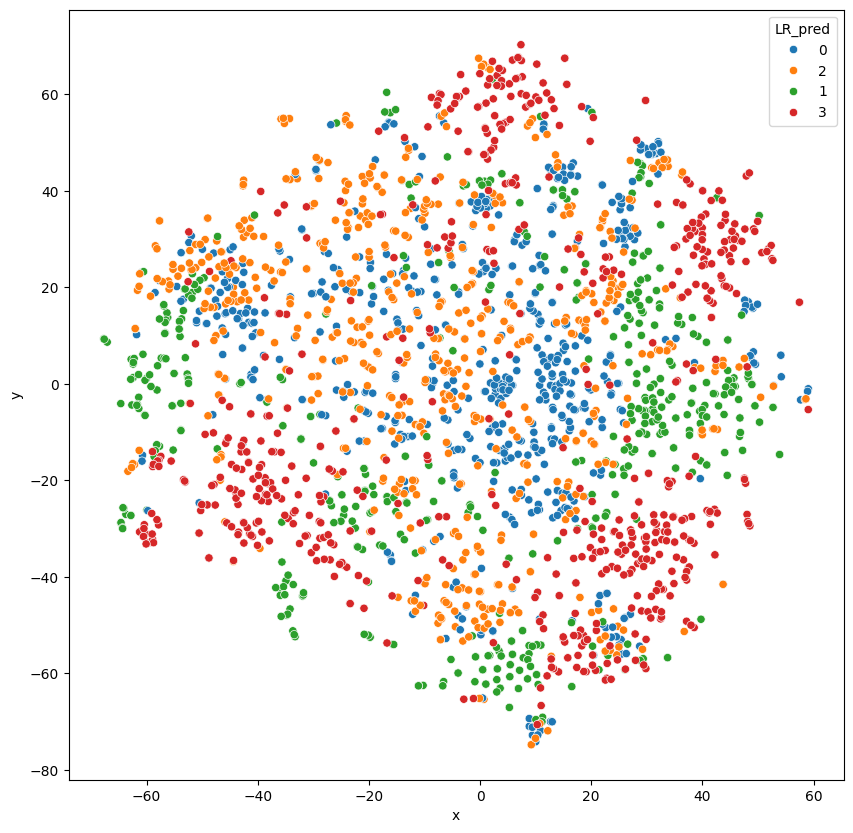

In [52]:
# plot the results using tsne

df_tsne["LR_pred"] = lr.predict(X)
df_tsne["LR_pred"] = df_tsne["LR_pred"].map(str)

plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_tsne, x="x", y="y", hue="LR_pred")

plt.show()

In [53]:
# get the top 20 attribute per weight

weights = lr.coef_

top20_attr = np.argsort(weights)[:, -20:]

for j in top20_attr[i]:
    print(f"Feature {j}: {df.columns[j+2]}")

Feature 300: defence
Feature 1800: occupied
Feature 102: ceasefire
Feature 436: joe
Feature 2310: kingdom
Feature 59: world
Feature 250: chief
Feature 243: uk
Feature 357: states
Feature 304: palestine
Feature 1841: guide
Feature 34: report
Feature 48: country
Feature 487: anti
Feature 50: international
Feature 32: state
Feature 958: icj
Feature 17: us
Feature 58: un
Feature 2: gaza


# RF - Random Forest Classifier

In [54]:
# use Random Forest with 10-fold cross validation

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

scores = cross_val_score(rf, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.03)


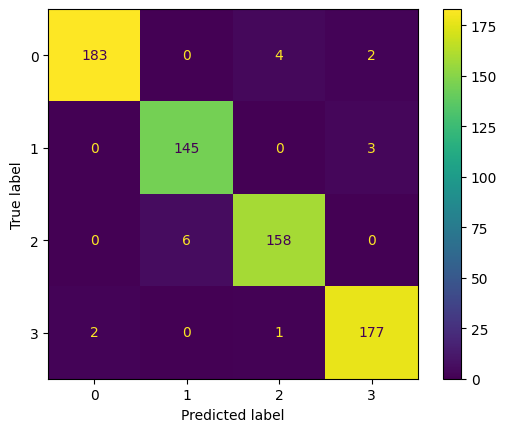

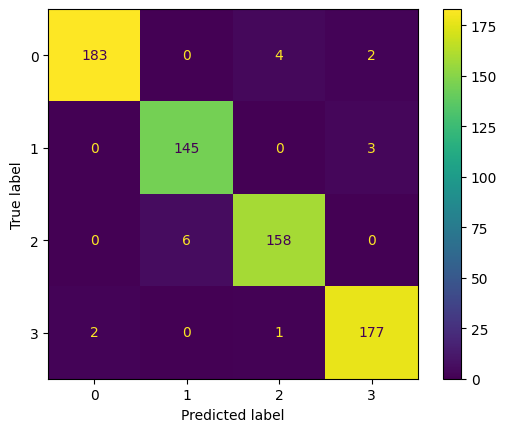

In [55]:
# same

# visualize the results of the classification for all the X

rf.fit(X_train, y_train)

disp = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)

disp.plot()

plt.show()

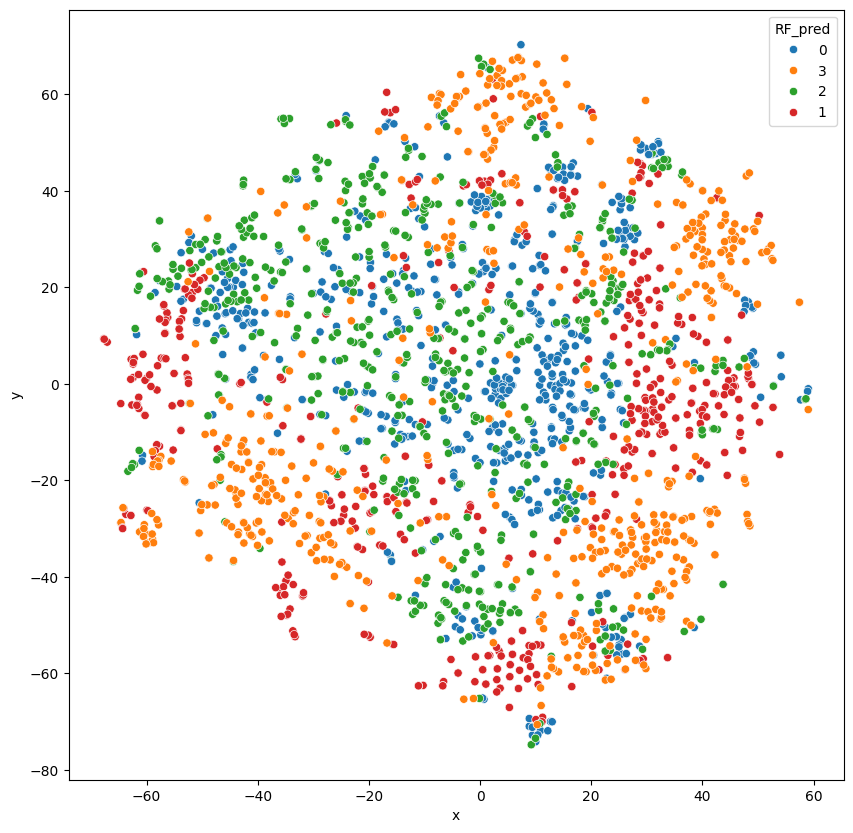

In [56]:
# plot the results using tsne

df_tsne["RF_pred"] = rf.predict(X)
df_tsne["RF_pred"] = df_tsne["RF_pred"].map(str)

plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_tsne, x="x", y="y", hue="RF_pred")

plt.show()

# ANN - Artificial Neural Network Classifier

We will build a NN using `tensorflow` and `keras` to classify the journal group.

The architecture of the NN is as follows:

- Embedding layer with 100 input dimensions.
- Hidden layer with 10 node and `relu` activation function.
- Hidden layer with 10 node and `relu` activation function.
- Hidden layer with 7 node and `relu` activation function.
- Output layer with 4 nodes and `softmax` activation function. (4 classes)

Seconde architecture:

- Embedding layer with 100 input dimensions.
- Hidden layer with 10 node and `gelu` activation function.
- Hidden layer with 10 node and `gelu` activation function.
- Hidden layer with 7 node and `gelu` activation function.
- Output layer with 4 nodes and `softmax` activation function. (4 classes)

In [57]:
X = X.astype(np.float32)
y = y.astype(int)

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense

model_1 = Sequential([
    Dense(100, activation='relu', input_shape=(X.shape[1],)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(7, activation='relu'),
    Dense(4, activation='softmax')
])

# compile the model
model_1.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# fit the model
history = model_1.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.3559 - loss: 1.3030 - val_accuracy: 0.6702 - val_loss: 0.9104
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7326 - loss: 0.7399 - val_accuracy: 0.8537 - val_loss: 0.4765
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9299 - loss: 0.2036 - val_accuracy: 0.8830 - val_loss: 0.3752
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9751 - loss: 0.0646 - val_accuracy: 0.8936 - val_loss: 0.3656
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9773 - loss: 0.0433 - val_accuracy: 0.8590 - val_loss: 0.4153
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0268 - val_accuracy: 0.8644 - val_loss: 0.4384
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.0143 - val_accuracy: 0.8830 - val_loss: 0.4421
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9930 - loss: 0.0126 - val_accuracy: 0.8830 - val_loss

In [60]:
# model 2

model_2 = Sequential(
    [
        Dense(100, activation="gelu", input_shape=(X.shape[1],)),
        Dense(10, activation="gelu"),
        Dense(10, activation="gelu"),
        Dense(7, activation="gelu"),
        Dense(4, activation="softmax"),
    ]
)

# compile the model
model_2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# fit the model
history = model_2.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.4332 - loss: 1.2011 - val_accuracy: 0.7766 - val_loss: 0.6309
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9318 - loss: 0.2934 - val_accuracy: 0.8351 - val_loss: 0.4277
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9942 - loss: 0.0411 - val_accuracy: 0.8404 - val_loss: 0.4190
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9963 - loss: 0.0135 - val_accuracy: 0.8511 - val_loss: 0.4447
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9967 - loss: 0.0112 - val_accuracy: 0.8617 - val_loss: 0.4231
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.8590 - val_loss: 0.4430
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8590 - val_loss: 0.4505
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.9089e-04 - val_accuracy: 0.8590 - val

In [61]:
# check the accuracy of the models

# model 1
loss, accuracy = model_1.evaluate(X_test, y_test)

print("Model 1 Accuracy: ", accuracy)

# model 2

loss, accuracy = model_2.evaluate(X_test, y_test)

print("Model 2 Accuracy: ", accuracy)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8711 - loss: 0.4473
Model 1 Accuracy:  0.8553191423416138
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8495 - loss: 0.4969
Model 2 Accuracy:  0.8425531983375549


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


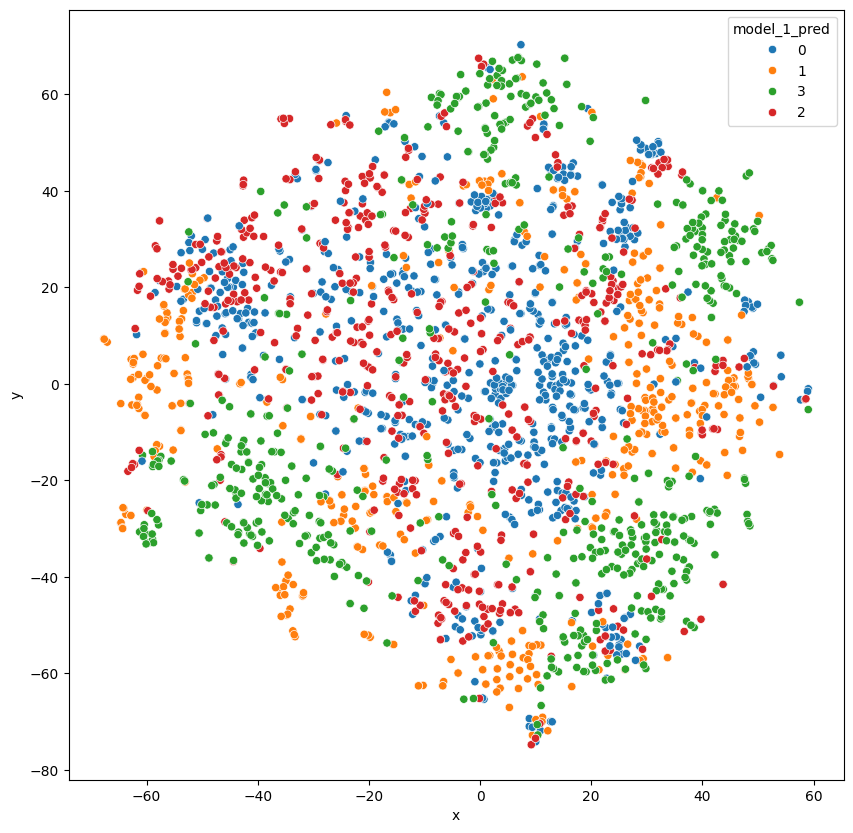

In [62]:
# plot the prediction for model 1

predictions = model_1.predict(X)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)


df_tsne["model_1_pred"] = [str(cls) for cls in predicted_classes]

plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_tsne, x="x", y="y", hue="model_1_pred")

plt.show()

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


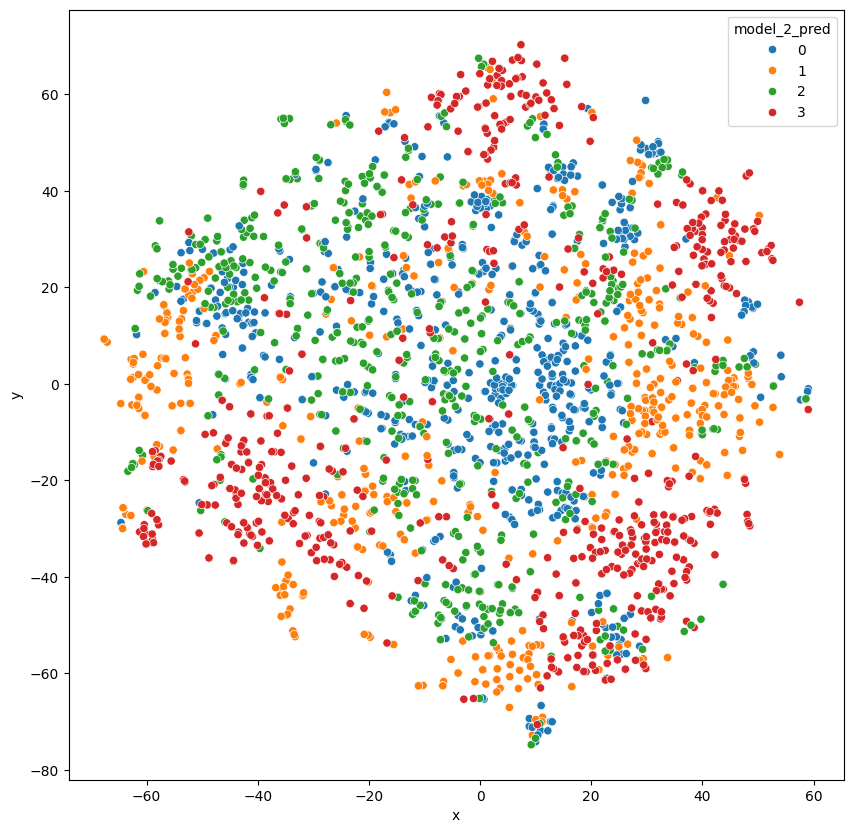

In [63]:
# plot the prediction for model 1

predictions = model_2.predict(X)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)


df_tsne["model_2_pred"] = [str(cls) for cls in predicted_classes]

plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_tsne, x="x", y="y", hue="model_2_pred")

plt.show()

In [65]:
# save the model into a file

model_1.save("model_1_tfidf-lemma.h5")

model_2.save("model_2_tfidf-lemma.h5")